by Shuyan Huang

# Imputing age and gender

## (a) 
Using the survey dataset, we can estimate models to predict gender and age by weight and total income, and then plug in weight and (labor income + capital income) in the BestIncome.txt dataset to impute gender and age. Here we assume that total income = labor income + capital income. We use log-linear model to predict gender and linear model to predict age. Following are our model equations:

$log(\frac{p(female_i)}{1-p(female_i)}) = \alpha_1 + \beta_{11} tot\_inc_i + \beta_{12} wgt_i$

$age_i = \alpha_2 + \beta_{21} tot\_inc_i + \beta_{22} wgt_i$

Where $tot\_inc_i = lab\_inc_i+cap\_inc_i$

## (b)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
BestIncome = pd.read_csv('BestIncome.txt', header=None)
SurvIncome = pd.read_csv('SurvIncome.txt', header=None)
Best_ary = BestIncome.values
Surv_ary = SurvIncome.values
Surv_female = Surv_ary[:,3]
Surv_age = Surv_ary[:,2]
Surv_x = Surv_ary[:,:2]
Surv_x = sm.add_constant(Surv_x)

model_female = sm.Logit(Surv_female,Surv_x).fit()
model_age = sm.OLS(Surv_age,Surv_x).fit()

Best_x = np.transpose([Best_ary[:,0]+Best_ary[:,1],Best_ary[:,3]])
Best_x = sm.add_constant(Best_x)
Best_female = model_female.predict(Best_x)
Best_female = np.array(list(map(lambda p: 0 if p<0.5 else 1, Best_female)))
Best_age = model_age.predict(Best_x)

Optimization terminated successfully.
         Current function value: 0.036050
         Iterations 11


## (c)

In [2]:
def descripstats(v):
    return {'mean':np.mean(v), 'std':np.std(v), 'min':min(v), 'max':max(v), 'nob':v.shape[0]}

descripstats(Best_age)

{'mean': 44.890828412990999,
 'std': 0.21913910572901438,
 'min': 43.976494892939144,
 'max': 45.703819001557932,
 'nob': 10000}

In [3]:
Best_female = np.array(Best_female)
descripstats(Best_female)

{'mean': 0.4546, 'std': 0.49793457401550256, 'min': 0, 'max': 1, 'nob': 10000}

## (d)

In [4]:
Best_new = np.concatenate((Best_ary, np.transpose([Best_age, Best_female])),axis=1)

In [5]:
np.corrcoef(Best_new)

array([[ 1.        ,  0.99907936,  0.99965113, ...,  0.99633716,
         0.99965026,  0.99348508],
       [ 0.99907936,  1.        ,  0.99986386, ...,  0.99175163,
         0.99986445,  0.98768175],
       [ 0.99965113,  0.99986386,  1.        , ...,  0.99373098,
         0.99999997,  0.99012846],
       ..., 
       [ 0.99633716,  0.99175163,  0.99373098, ...,  1.        ,
         0.99372741,  0.99959121],
       [ 0.99965026,  0.99986445,  0.99999997, ...,  0.99372741,
         1.        ,  0.99012401],
       [ 0.99348508,  0.98768175,  0.99012846, ...,  0.99959121,
         0.99012401,  1.        ]])

# Stationary and data drfit

## (a)

In [6]:
IncomeIntel = pd.read_csv('IncomeIntel.txt', header=None)
IncomeIntel_ary  = IncomeIntel.values
gre_qnt = IncomeIntel_ary[:,1]
salary_p4 = IncomeIntel_ary[:,2]
x =  sm.add_constant(gre_qnt)

model_incomeintel = sm.OLS(salary_p4, x).fit()

model_incomeintel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.277
Date:                Thu, 11 Oct 2018   Prob (F-statistic):              0.132
Time:                        14:03:33   Log-Likelihood:                -10507.
No. Observations:                1000   AIC:                         2.102e+04
Df Residuals:                     998   BIC:                         2.103e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.902e+04    744.576     79.260      0.000    5.76e+04    6.05e+04
x1             1.7423      1.154      1.509      0.132      -0.523       4.008
==============================================================================
Omnibus:                        1.692   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.655
Skew:                           0.009   Prob(JB):                        0.437
Kurtosis:                       3.198   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As can be seen from the summary chart, the estimated coefficients are $\beta_0=59020$ and $\beta_1=1.7423$, the corresponding standard errors are 744.576 and 1.154

## (b)

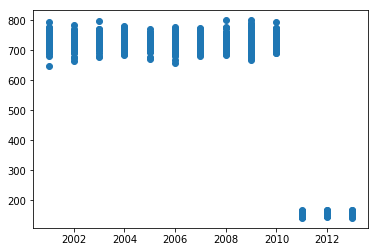

In [7]:
import matplotlib.pyplot as plt
plt.scatter(IncomeIntel_ary[:,0], gre_qnt)

A drift in the GRE quantitative score scale happened in 2011, which will affect the estimated coefficients and the statistical significance of the regression results. A change in variable scale means that the coefficients in the two time period are different. A solution to this problem is to standardize the GRE quantitative score by z score within each year. Instead of using the raw score, we use the relative score, which is not affected by the change of scale.

In [8]:
IncomeIntel.columns = ['grad_year', 'gre_qnt', 'salary_p4']

In [9]:
IncomeIntel['gre_qnt'] = IncomeIntel.groupby('grad_year').transform(lambda x: (x - x.mean()) / x.std())['gre_qnt']

gre_qnt_new = IncomeIntel['gre_qnt'].values

x_new =  sm.add_constant(gre_qnt_new)

## (c)

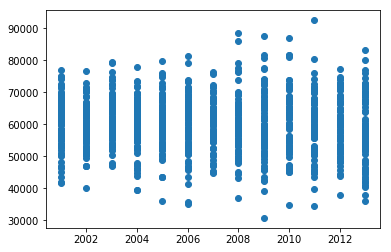

In [10]:
plt.scatter(IncomeIntel_ary[:,0], salary_p4)

In [11]:
 IncomeIntel.groupby('grad_year').mean()

,gre_qnt,salary_p4
grad_year,,
2001.0,-2.275642e-15,60838.451338
2002.0,2.390945e-15,59153.892438
2003.0,1.047791e-14,61933.955229
2004.0,9.005783e-15,60082.972426
2005.0,-3.734387e-15,60446.862671
2006.0,3.771875e-15,59879.706881
2007.0,1.089172e-14,59527.961768
2008.0,8.398765e-17,60204.841721
2009.0,1.214036e-15,59972.927510


From the scatter plot and the chart above, we can see that although very slightly, the mean of the salary over years are changing. To make the salary data stationary over time, we standardize the salary by the following equation:

$standardized(salary_{ti}) = salary_{ti} \frac{mean(salary_{2001})}{mean(salary_t)}$

In [14]:
mean2001 = IncomeIntel.groupby('grad_year').mean().loc[2001.0, 'salary_p4']

IncomeIntel['salary_p4'] = IncomeIntel.groupby('grad_year').transform(lambda x: x*mean2001/x.mean())['salary_p4'] 
salary_p4_new = IncomeIntel['salary_p4'].values

## (d)

In [15]:
model_incomeintel_new = sm.OLS(salary_p4_new, x_new).fit()

model_incomeintel_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7072
Date:                Thu, 11 Oct 2018   Prob (F-statistic):              0.401
Time:                        14:05:32   Log-Likelihood:                -10518.
No. Observations:                1000   AIC:                         2.104e+04
Df Residuals:                     998   BIC:                         2.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.084e+04    283.227    214.804      0.000    6.03e+04    6.14e+04
x1           239.7432    285.086      0.841      0.401    -319.695     799.181
==============================================================================
Omnibus:                        1.816   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.797
Skew:                           0.014   Prob(JB):                        0.407
Kurtosis:                       3.206   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As can be seen from the summary chart, the estimated coefficients are $\beta_0=60840$ and $\beta_1=239.7432$, the corresponding standard errors are 283.227 and 285.086. $\beta_0$ and its std don't change much but $\beta_1$ and its std in the new regression are over 100 times of those in the original regression. That's because the standardization we did to the GRE quantitative score decreased the scale of this data by over 100 times, while the standardization we did to the salary didn't change the overall scale of it. Since the coefficient $\beta_1$ is not statistically significant, the regression result gives no evidence that higher intelligence is associated with higher income.

# Assessment of Koissinets and Watts

## (a)
What roles do choice homophily and induced homophily play in the emergency of homophily (the observed tendency of people associating with similar people) through the process of individuals in a social network seletively make or break ties with others?

## (b)
The data is based on the population of 30,396 undergraduate and graduate students, faculty, and staff in a large U.S. university, consisting of 3 datasets: 
1. the logs of e-mail interactions within the university over one academic year, 
2. a database of individual attributes (status, gender, age, department, number of years in the community, etc.),
3. records of course registration

The number of observations is 30396 for personal characteristics, organizational affiliations, and course-related variables. The total number of email interaction is 7,156,162. And the time period of the data is 270 days.

In APPENDIX A, we can find a description and definition of all variables.

## (c)
To ensure that the data represent interpersonal communication, the authors included only email messages that were sent to a single recipient. This cleared away about 18% of all emails. But in a university context, group emails actually contain a lot of interpersonal communication. For example professors often email their research assistant in a group rather than in person, so that people in the group will know what each other is doing. This might be a unique type of interpersonal communication and eliminating it can lead to loss of a propable source of homophily.

## (d)
E-mail exchanges comprise discrete and intermittent “spike trains” that are often “bursty” in nature (Cortes et al. 2003; Eckmann, Moses, and Sergi 2004). It's hard to decide the timing of the formation and dissolution a social link based on a time series of email exchanges between two persons. To address this problem, the authors defined the instantaneous strength of a dyad at time t based on the number of email exchanges in time window $\tau$ and sampling period $\delta$. By carefully choosing $\tau$, they decide the maximum time at which a past interaction is assumed to contribute to the current strength of relationship. And $\delta$ determines whether events separated in time will be treated as sequential or as simultaneous with one another.